In [1]:
import numpy as np
from pyrex.main import *
from pyrex.core import *
import matplotlib.pyplot as plt
import lal
import lalsimulation as ls
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter.matchedfilter import make_frequency_series
from pycbc.filter import matched_filter_core,sigmasq
from pycbc.types import complex_same_precision_as

In [2]:
data_path = "/Users/yesety/Documents/AEI/projects/eccentric/catalog_ecc/"

name=[]
name.append(['SXS_BBH_0180','SXS_BBH_1355','SXS_BBH_1357','SXS_BBH_1358','SXS_BBH_1359','SXS_BBH_1360','SXS_BBH_1361','SXS_BBH_1362','SXS_BBH_1363'])
name.append(['SXS_BBH_0184','SXS_BBH_1364','SXS_BBH_1365','SXS_BBH_1366','SXS_BBH_1367','SXS_BBH_1368','SXS_BBH_1369'])
name.append(['SXS_BBH_0183','SXS_BBH_1372','SXS_BBH_1373','SXS_BBH_1374'])

e_comm=[]
e_comm.append([0,0.053,0.097,0.099,0.100,0.142,0.144,0.189,0.192])
e_comm.append([0,0.044,0.06,0.095,0.096,0.097,0.185])
e_comm.append([0,0.092,0.093,0.18]) #Hinder Phys Rev D 98 2018

l_comm=[]
l_comm.append([0.667,-2.788,1.371,-1.742,2.743,2.178,1.550,1.042,0.732])
l_comm.append([-0.604,2.144,1.938,1.013,-0.709,-1.963,-1.465])
l_comm.append([1.818,2.998,1.677,-0.265]) #Hinder Phys Rev D 98 201

q=[]
q.append(list(np.ones(len(e_comm[0]))+0))
q.append(list(np.ones(len(e_comm[1]))+1))
q.append(list(np.ones(len(e_comm[2]))+2))

data={}
data['name']=name[0]+name[1]+name[2]
data['e_comm']=e_comm[0]+e_comm[1]+e_comm[2]
data['q']=q[0]+q[1]+q[2]
data['l_comm']=l_comm[0]+l_comm[1]+l_comm[2]

In [3]:
data_training={}
data_training['name']=np.concatenate([data['name'][:3],data['name'][7:11],data['name'][14:17],data['name'][18:]])
data_training['e_comm']=np.concatenate([data['e_comm'][:3],data['e_comm'][7:11],data['e_comm'][14:17],data['e_comm'][18:]])
data_training['q']=np.concatenate([data['q'][:3],data['q'][7:11],data['q'][14:17],data['q'][18:]])
data_training['l_comm']=np.concatenate([data['l_comm'][:3],data['l_comm'][7:11],data['l_comm'][14:17],data['l_comm'][18:]])

data_test={}
for i in range(len(data['name'])):
    if data['name'][i] not in data_training['name']:
        data_test.setdefault('name', []).append(data['name'][i])
        data_test.setdefault('e_comm', []).append(data['e_comm'][i])
        data_test.setdefault('q', []).append(data['q'][i])
        data_test.setdefault('l_comm', []).append(data['l_comm'][i])

In [4]:
data_all=Glassware(q=data['q'],chi=0,data_path=data_path,names=data['name'],e_ref=data['e_comm'],outfname='../data/all.pkl')

In [5]:
training=Glassware(q=data_training['q'],chi=0,data_path=data_path,names=data_training['name'],e_ref=data_training['e_comm'])

In [6]:
for i in range(len(data_all.names)):
    if data_all.names[i] not in training.names:
        data_test.setdefault('h22', []).append(data_all.h22[i])
        data_test.setdefault('time', []).append(data_all.time[i])

In [7]:
x_test=[]
for i in range(len(data['name'])):
    if data['name'][i] not in data_training['name']:
        x_test.append(data_all.x[i])
x_test

[0.14137733594267635,
 0.13275716741866606,
 0.11026178330402492,
 0.11961614256645847,
 0.12375586331071667,
 0.1429315653824314,
 0.13822550574078415,
 0.1259671936934662]

In [8]:
total_mass=50.

approximant1='IMRPhenomD'
approximant2='SEOBNRv4'
spin1x=0.
spin1y=0.
spin1z=0.
spin2x=0.
spin2y=0.
spin2z=0.

inclination=0.
distance=1.
coa_phase=0.

In [9]:
_snr = None
def modify_match(vec1, vec2, vec3, vec4, psd=None, low_frequency_cutoff=None,
          high_frequency_cutoff=None, v1_norm=None, v2_norm=None):
    """ Return the match between the two TimeSeries or FrequencySeries.

    Return the match between two waveforms. This is equivalent to the overlap
    maximized over time and phase.

    Parameters
    ----------
    vec1 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    vec2 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    psd : Frequency Series
        A power spectral density to weight the overlap.
    low_frequency_cutoff : {None, float}, optional
        The frequency to begin the match.
    high_frequency_cutoff : {None, float}, optional
        The frequency to stop the match.
    v1_norm : {None, float}, optional
        The normalization of the first waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    v2_norm : {None, float}, optional
        The normalization of the second waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.

    Returns
    -------
    match: float
    index: int
        The number of samples to shift to get the match.
    """
    
    htilde = make_frequency_series(vec1)    
    stilde = make_frequency_series(vec2)
    h_imag=make_frequency_series(vec3)*1j
    s_im=make_frequency_series(vec4)*1j
    htilde=htilde+h_imag
    stilde=stilde+s_im
    
    

    N = (len(htilde)-1) * 2

    global _snr
   
    if _snr is None or _snr.dtype != htilde.dtype or len(_snr) != N:
        _snr = np.zeros(N,dtype=complex_same_precision_as(vec1))
   
    snr, a, snr_norm = matched_filter_core(htilde,stilde,psd,low_frequency_cutoff,high_frequency_cutoff, v1_norm, out=None)
    maxsnr, max_id = snr.abs_max_loc()
    if v2_norm is None:
        v2_norm = sigmasq(stilde, psd, low_frequency_cutoff, high_frequency_cutoff)
    return maxsnr * snr_norm / np.sqrt(v2_norm), max_id

In [10]:
def resizeWave(time,strain,newtime):
    inter_real=spline(time,np.real(strain))
    inter_im=spline(time,np.imag(strain))
    time_real=TimeSeries(inter_real(newtime),delta_t=1./4096)
    time_im=TimeSeries(inter_im(newtime),delta_t=1./4096)
    return time_real,time_im

def compute_match(testtime,testh,timemodel,mdlh,newtm):
    nrdt,nid=resizeWave(testtime,testh,newtm)
    mdt,mdi=resizeWave(timemodel,np.real(mdlh)-np.imag(mdlh)*1j,newtm)    
    f_lower=25.
    tlen=len(nrdt)
    delta_f = 1.0 / nrdt.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_lower)
    cmatch=modify_match(nrdt,mdt,nid,mdi,psd=psd,low_frequency_cutoff=f_lower)
    return cmatch[0]

In [20]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(data_test['e_comm'][i],data_test['q'][i],matchPhnm,matchSEOB)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.099 1.0 0.9985915774856771 0.9993322412536595
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.1 1.0 0.9992166905589198 0.998617599657509
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.142 1.0 0.9981506511120233 0.9971282568761394
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.144 1.0 0.9994587951838807 0.9991502649668824
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.06 2.0 0.9999958706113966 0.9999951374129685
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.095 2.0 0.9998302194458598 0.9999022471921913
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.096 2.0 0.9999795828545791 0.9999850481657244
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.092 3.0 0.9987384037039512 0.999753429129794


In [11]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):    
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(data_test['e_comm'][i],data_test['q'][i],matchPhnm,matchSEOB)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.099 1.0 0.998590292832784 0.9993317379570815
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.1 1.0 0.9992171756019113 0.9986179349297406
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.142 1.0 0.9981500817005441 0.9971277974802755
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.144 1.0 0.9994586776517941 0.9991501855842694
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.06 2.0 0.999995878043741 0.9999951363371947
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.095 2.0 0.9998302811241851 0.9999022737129439
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.096 2.0 0.9999795880000645 0.9999850399346019
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.092 3.0 0.9987379706347959 0.9997532654233344


training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


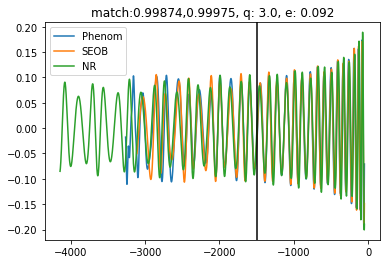

In [12]:
i=7    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(np.pi/2*1j),label='SEOB')
plt.plot(data_test['time'][7],data_test['h22'][7]*np.exp(-np.pi/2*1j),label='NR')
plt.legend()
plt.title('match:'+str(round(matchPhnm,5))+','+str(round(matchSEOB,5))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500,ymin=-0.7,ymax=1,color='k')
#plt.xlim(-1500,30)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


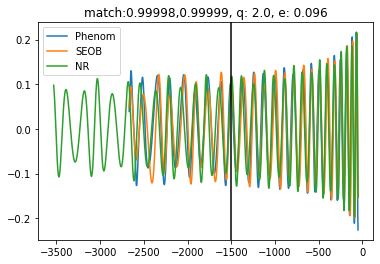

In [13]:
i=6    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],-testSEOB.h22[50:]*np.exp(19j),label='SEOB')
plt.plot(data_test['time'][i],data_test['h22'][i]*np.exp(np.pi/2*1j),label='NR')
plt.legend()
plt.title('match:'+str(round(matchPhnm,5))+','+str(round(matchSEOB,5))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500,ymin=-0.7,ymax=1,color='k')
#plt.xlim(-1500,25)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


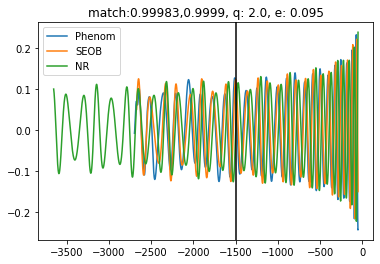

In [14]:
i=5    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],-testSEOB.h22[50:]*np.exp(19j),label='SEOB')
plt.plot(data_test['time'][i],data_test['h22'][i]*np.exp(np.pi/2*1j),label='NR')
plt.legend()
plt.title('match:'+str(round(matchPhnm,5))+','+str(round(matchSEOB,5))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500,ymin=-0.7,ymax=1,color='k')
#plt.xlim(-1500,25)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


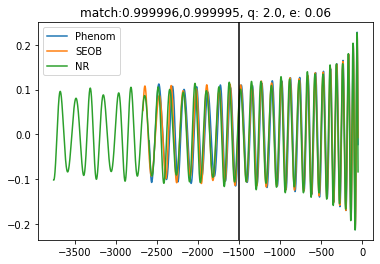

In [15]:
i=4   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],-testSEOB.h22[50:]*np.exp(19j),label='SEOB')
plt.plot(data_test['time'][i],data_test['h22'][i]*np.exp(-np.pi/3*1j),label='NR')
plt.legend()
plt.title('match:'+str(round(matchPhnm,6))+','+str(round(matchSEOB,6))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500,ymin=-0.7,ymax=1,color='k')
#plt.xlim(-1500,25)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


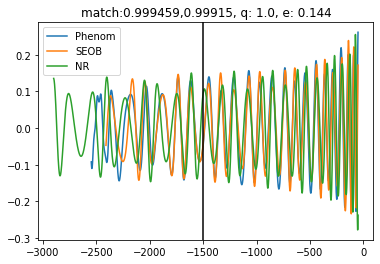

In [16]:
i=3   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],-testSEOB.h22[50:]*np.exp(-1./3*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i],data_test['h22'][i]*np.exp(2./3*np.pi*1j),label='NR')
plt.legend()
plt.title('match:'+str(round(matchPhnm,6))+','+str(round(matchSEOB,6))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500,ymin=-0.7,ymax=1,color='k')
#plt.xlim(-1500,25)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


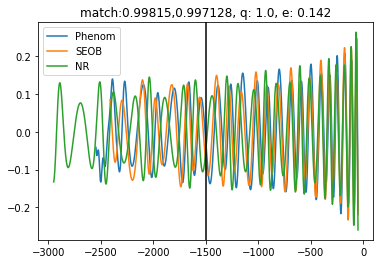

In [17]:
i=2   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],-testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i],data_test['h22'][i]*np.exp(-20j),label='NR')
plt.legend()
plt.title('match:'+str(round(matchPhnm,6))+','+str(round(matchSEOB,6))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500,ymin=-0.7,ymax=1,color='k')
#plt.xlim(-1500,25)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


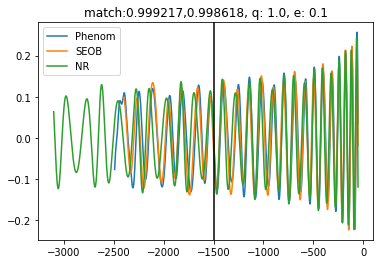

In [18]:
i=1   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],-testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i],data_test['h22'][i]*np.exp(20j),label='NR')
plt.legend()
plt.title('match:'+str(round(matchPhnm,6))+','+str(round(matchSEOB,6))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500,ymin=-0.7,ymax=1,color='k')
#plt.xlim(-1500,25)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


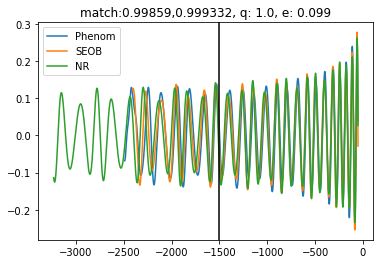

In [19]:
i=0   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],-testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i],data_test['h22'][i]*np.exp(-1./5*np.pi*1j),label='NR')
plt.legend()
plt.title('match:'+str(round(matchPhnm,6))+','+str(round(matchSEOB,6))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500,ymin=-0.7,ymax=1,color='k')
#plt.xlim(-1500,25)

In [11]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],np.real(testPhenom.h22)-np.imag(testPhenom.h22)*1j,newt)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],np.real(testSEOB.h22)-np.imag(testSEOB.h22)*1j,newt)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(data_test['e_comm'][i],data_test['q'][i],matchPhnm,matchSEOB)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.099 1.0 0.9985915774856771 0.9993322412536595
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.1 1.0 0.9992166905589198 0.998617599657509
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.142 1.0 0.9981506511120233 0.9971282568761394
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.144 1.0 0.9994587951838807 0.9991502649668824
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.06 2.0 0.9999958706113965 0.9999951374129687
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.095 2.0 0.9998302194458598 0.9999022471921913
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.096 2.0 0.9999795828545791 0.9999850481657245
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.092 3.0 0.9987384037039512 0.999753429129794


In [16]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i]+1,total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]+0.6
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],np.real(testPhenom.h22)-np.imag(testPhenom.h22)*1j,newt)
    #matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],np.real(testSEOB.h22)-np.imag(testSEOB.h22)*1j,newt)
    eccen_matchphen.append(matchPhnm)
    #ecccen_matchseob.append(matchSEOB)
    print(eccentricity,data_test['q'][i]+6,matchPhnm)

(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.699 7.0 0.9881099704596217
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.7 7.0 0.9993154578778494
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.742 7.0 0.9995240902394029
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.744 7.0 0.9986118588044893
(warni

In [28]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]+0.8
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],np.real(testPhenom.h22)-np.imag(testPhenom.h22)*1j,newt)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],np.real(testSEOB.h22)-np.imag(testSEOB.h22)*1j,newt)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(eccentricity,data_test['q'][i],matchPhnm,matchSEOB)

(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.899 1.0 0.9993793882023043 0.9963945538728098
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.9 1.0 0.999385098850847 0.9989505692946458
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.9420000000000001 1.0 0.9994810986016939 0.9989317277559208
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
tr

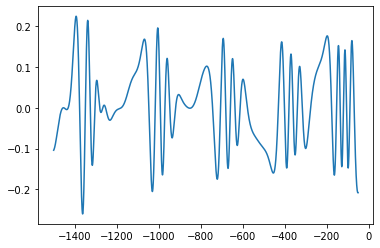

In [29]:
plt.plot(newt,testPhenom.h22)

In [32]:
(-5)**(-59./24)

(0.0024968727409565034-0.018965631391071658j)

In [20]:
eccentricity

0.7919999999999999

In [14]:
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.interpolate import interp1d

xd=np.array([1.0, 2.0, 3.0])
yd=np.array([0.02022989114435405, 0.011019010177865768, 0.004272561131275679])
print(yd)

intr=interp1d(xd,yd,fill_value='extrapolate')
intr(4.),np.sqrt(0.021952323100004043)

[0.02022989 0.01101901 0.00427256]


(array(-0.00247389), 0.1481631637756296)

In [21]:
interp1d?

In [20]:
testPhenom.omega_keys

[0.18295450921304296, 0.0004183486200610664, nan, -1.5466713646924561]

In [34]:
from scipy import interpolate
def interp1D(trainkey,trainval,testkey):
    '''
        Interpolate 1D.
    '''
    if testkey<min(trainkey) or testkey>min(trainkey):
        print(testkey)
        interp=interpolate.interp1d(trainkey,trainval, fill_value='extrapolate')
        result=interp(testkey)
    else:
        interp=interpolate.interp1d(trainkey,trainval)
        result=interp(testkey)
    return result

In [22]:
np.abs(data_all.freq_omega)

array([0.99999924, 0.10683231, 0.10679544, 0.10600286, 0.10650194,
       0.10573957, 0.10493278, 0.10336903, 0.10361335, 1.00000218,
       0.1184124 , 0.11854805, 0.11689195, 0.11768384, 0.11774015,
       0.11416517, 0.99999845, 0.13555259, 0.13484159, 0.1319446 ])

In [83]:
result=interp1D(np.array([q_noncirc[0],q_noncirc[10],q_noncirc[15]]),np.array([fr_omg_noncirc[0],fr_omg_noncirc[10],fr_omg_noncirc[15]])**2,7)
print(np.sqrt(result))

7
0.190411036155655


In [79]:
np.array([q_noncirc[0],q_noncirc[10],q_noncirc[15]])

array([1., 2., 3.])

In [67]:
(fr_omg_noncirc**2)*1e4

array([114.13142724, 114.05265388, 112.36606232, 113.4266256 ,
       111.80857545, 110.10888744, 106.85156801, 107.35725289,
       140.21497543, 140.53640826, 136.63727732, 138.49486297,
       138.62741878, 130.33685794, 183.74503401, 181.82254723,
       174.09376782])

In [58]:
e_noncirc=np.concatenate((np.concatenate((data_all.e_ref[1:9],data_all.e_ref[10:16]),axis=0),data_all.e_ref[17:]),axis=0)
q_noncirc=np.concatenate((np.concatenate((data_all.q[1:9],data_all.q[10:16]),axis=0),data_all.q[17:]),axis=0)

A_omg_noncirc=np.concatenate((np.concatenate((data_all.A_omega[1:9],data_all.A_omega[10:16]),axis=0),data_all.A_omega[17:]),axis=0)
C_omg_noncirc=np.concatenate((np.concatenate((data_all.B_omega[1:9],data_all.B_omega[10:16]),axis=0),data_all.B_omega[17:]),axis=0)
fr_omg_noncirc=np.concatenate((np.concatenate((data_all.freq_omega[1:9],data_all.freq_omega[10:16]),axis=0),data_all.freq_omega[17:]),axis=0)
phi_omg_noncirc=np.concatenate((np.concatenate((data_all.phi_omega[1:9],data_all.phi_omega[10:16]),axis=0),data_all.phi_omega[17:]),axis=0)

In [15]:
e_noncirc=np.concatenate((np.concatenate((data_all.e_ref[1:9],data_all.e_ref[10:16]),axis=0),data_all.e_ref[17:]),axis=0)
q_noncirc=np.concatenate((np.concatenate((data_all.q[1:9],data_all.q[10:16]),axis=0),data_all.q[17:]),axis=0)

AA_noncirc=np.concatenate((np.concatenate((data_all.A_amp[1:9],data_all.A_amp[10:16]),axis=0),data_all.A_amp[17:]),axis=0)
CA_noncirc=np.concatenate((np.concatenate((data_all.B_amp[1:9],data_all.B_amp[10:16]),axis=0),data_all.B_amp[17:]),axis=0)
frA_noncirc=np.concatenate((np.concatenate((data_all.freq_amp[1:9],data_all.freq_amp[10:16]),axis=0),data_all.freq_amp[17:]),axis=0)
phiA_noncirc=np.concatenate((np.concatenate((data_all.phi_amp[1:9],data_all.phi_amp[10:16]),axis=0),data_all.phi_amp[17:]),axis=0)

In [106]:
d = {}
newtr=[]
newq=[]

for a, b in zip(list(q_noncirc), list(fr_omg_noncirc**2)):
    d.setdefault(a, []).append(b)

for key in d:
    newtr.append(key)
    newq.append(sum(d[key])/len(d[key]))
    print(key, np.sqrt(sum(d[key])/len(d[key])))

1.0 0.105481221837845
2.0 0.11724957716361087
3.0 0.13412200280126493


In [107]:
d = {}
la=np.array([1,2,2,3])
lb=np.array([2,3,4,5])

for a, b in zip(list(la), list(lb)):
    d.setdefault(a, []).append(b)

for key in d:
    print(key, sum(d[key])/len(d[key]))

1 2.0
2 3.5
3 5.0


In [97]:
np.average(fr_omg_noncirc[:8])

0.0006016163574259596

In [102]:
np.sqrt(interp1D(newtr,newq,4))

4


0.14909714928797096

In [96]:
q_noncirc[:8],fr_omg_noncirc[:8]

(array([1., 1., 1., 1., 1., 1., 1., 1.]),
 array([ 0.10683231,  0.10679544, -0.10600286, -0.10650194,  0.10573957,
         0.10493278, -0.10336903, -0.10361335]))

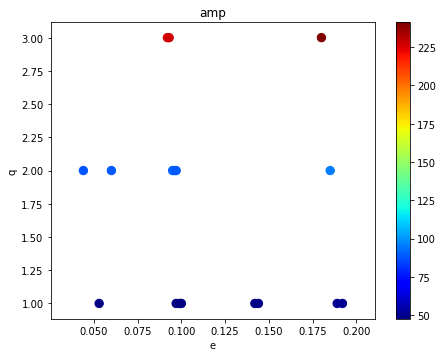

In [18]:
plt.figure(figsize=(16,12))
cm=plt.cm.get_cmap('jet')
plt.subplot(221)
sc1=plt.scatter(e_noncirc,q_noncirc,c=1./(frA_noncirc**2),cmap=cm,s=70)
plt.xlabel('e')
plt.ylabel('q')
plt.title('amp')
plt.colorbar(sc1)

In [27]:
(1-np.asarray(eccen_matchphen))/(1-np.asarray(cir_mtchphnm))


array([0.28777054, 0.14541152, 0.60170066, 0.23683505, 0.00228941,
       0.06840381, 0.01152556, 0.38499307])

In [25]:
(1-np.asarray(ecccen_matchseob))/(1-np.asarray(cir_mtchseob))


array([0.13643481, 0.25662951, 0.93432832, 0.37184476, 0.00269594,
       0.03938511, 0.00844049, 0.075243  ])

In [13]:
(1-np.asarray(eccen_matchphen))/(1-np.asarray(cir_mtchphnm))


array([0.48929457, 0.11035758, 0.48753381, 0.22688481, 0.00173597,
       0.05681526, 0.01287846, 0.31275326])

In [14]:
(1-np.asarray(ecccen_matchseob))/(1-np.asarray(cir_mtchseob))


array([0.25910195, 0.18763733, 0.74495356, 0.38245251, 0.0019713 ,
       0.02992063, 0.01276389, 0.04184065])